# Índice

- Preparar el Entorno
- Cargar los Datos
- Modelado
  - Modelo de Machine Learning
      - Random Forest Regressor
      - Kernel Ridge
      - Gradient Boosting Regressor
  - Red Neuronal para Datos Tabulares
  - Red Neuronal para Imágenes

# Preparar el Entorno

In [3]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2
import imageio.v3 as io

from tqdm import tqdm
from typing import Optional, Union

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Normalization
from tensorflow.keras.optimizers import Adam, SGD

# Establecer opciones de visualización para mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar  3 16:10:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Comprobar la versión de tensorflow
print(tf.__version__)

2.15.0


# Cargar los Datos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Carga los DataFrames desde los archivos CSV (sin escalar)
X_train = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_train_filtered.csv')
X_val = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_val_filtered.csv')
X_test = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_test_filtered.csv')
y_train = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_train_filtered.csv')
y_val = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_val_filtered.csv')
y_test = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_test_filtered.csv')

In [5]:
# Carga los DataFrames desde los archivos CSV (escalados)
X_train_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_train_escalado.csv')
X_val_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_val_escalado.csv')
X_test_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/X_test_escalado.csv')
y_train_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_train_escalado.csv')
y_val_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_val_escalado.csv')
y_test_scaled = pd.read_csv('/content/drive/MyDrive/deep_learning/train_test_split/y_test_escalado.csv')

In [6]:
# Cargar las imágenes
imagenes_cargadas = np.load('/content/drive/My Drive/deep_learning/imagenes_procesadas.npy')
imagenes_train = np.load('/content/drive/My Drive/deep_learning/imagenes_train.npy')
imagenes_val = np.load('/content/drive/My Drive/deep_learning/imagenes_val.npy')
imagenes_test = np.load('/content/drive/My Drive/deep_learning/imagenes_test.npy')

Para el modelado, se han utilizado conjuntos de datos tanto *escalados* como *no escalados*, abarcando **características tabulares y conjuntos de imágenes** correspondientes a los listados de Airbnb. Los datos tabulares incluyen información detallada sobre cada alojamiento, mientras que los datos de imágenes se componen de fotografías de las propiedades. Incluir ambos tipos de datos puede proporcionar una comprensión más profunda de los factores que influyen en los precios de los alojamientos.

# Modelado

## Modelo de Machine Learning

Inicialmente, se replicó un enfoque de machine learning utilizado en el [proyecto anterior de Machine Learning](https://github.com/rociobenitez/AirbnbPricingModel), adaptándolo a un conjunto de datos más amplio y diverso.

Aquí se experimenta con tres modelos diferentes:

- **Random Forest Regressor:** Seleccionado por su capacidad para manejar características no lineales y su robustez frente a los outliers.

- **Kernel Ridge:** Elegido por su eficacia en problemas de regresión con datos de alta dimensión.

- **Gradient Boosting Regressor:** Optamos por este modelo debido a su flexibilidad y potencia para mejorar progresivamente el rendimiento.


In [7]:
# Función para calcular múltiples métricas
def compute_metrics(y_true, y_pred):
    metrics = {
        'MAE': round(mean_absolute_error(y_true, y_pred),3),
        'MSE': round(mean_squared_error(y_true, y_pred),3),
        'RMSE': round(mean_squared_error(y_true, y_pred, squared=False),3),
        'R2': round(r2_score(y_true, y_pred),3)
    }
    return metrics

### Random Forest Regressor

Fitting 3 folds for each of 14 candidates, totalling 42 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=1; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=1; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=1; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=2; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=2; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=2; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=3; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=3; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=3; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=4; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=4; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=4; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=6; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=6; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=6; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=7; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=7; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=8; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=8; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=8; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=9; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=9; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ........................................max_depth=9; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=10; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=10; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=10; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=11; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=11; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=11; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=12; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=12; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=12; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=13; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=13; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=13; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=14; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=14; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................................max_depth=14; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


best mean cross-validation score: 0.585
best parameters: {'max_depth': 11}


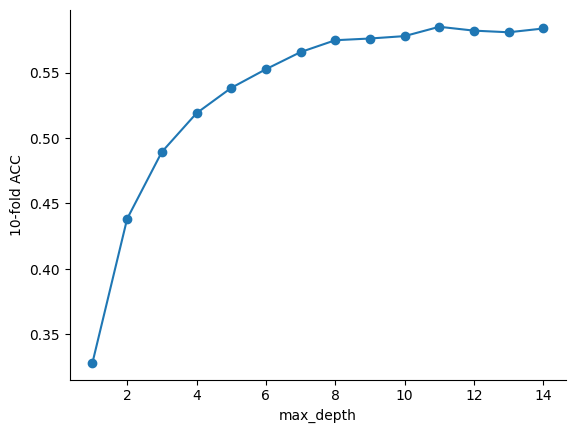

In [15]:
from sklearn.ensemble import RandomForestRegressor

maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(
    RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'),
    param_grid=tuned_parameters, cv=3, verbose=2)

grid.fit(X_train_scaled, y_train_scaled)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [16]:
# Evaluación de Random Forest
maxDepthOptimo = grid.best_params_['max_depth']
randomForest = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train_scaled,y_train_scaled)

print("Train: ",randomForest.score(X_train_scaled,y_train_scaled))
print("Validación: ",randomForest.score(X_val_scaled,y_val_scaled))

<ipython-input-16-4c4b3bf969bb>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomForest = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train_scaled,y_train_scaled)


Train:  0.8449160648164764
Validación:  0.5311194352987771


MAE: 0.031
MSE: 0.004
RMSE: 0.06
R2: 0.531


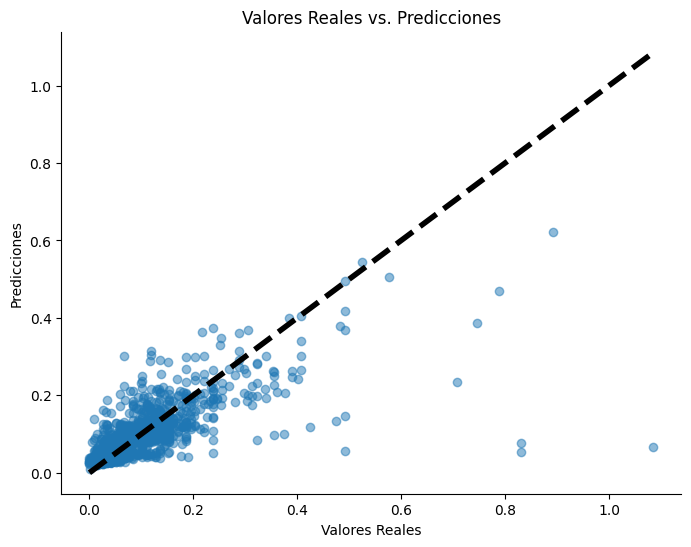

In [17]:
y_pred = randomForest.predict(X_val_scaled)

# Métricas
metrics = compute_metrics(y_val_scaled, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

plt.figure(figsize=(8, 6))
plt.scatter(y_val_scaled, y_pred, alpha=0.5)
plt.plot([y_val_scaled.min(), y_val_scaled.max()], [y_val_scaled.min(), y_val_scaled.max()], 'k--', lw=4)  # Línea de perfecta predicción
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Valores Reales vs. Predicciones')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

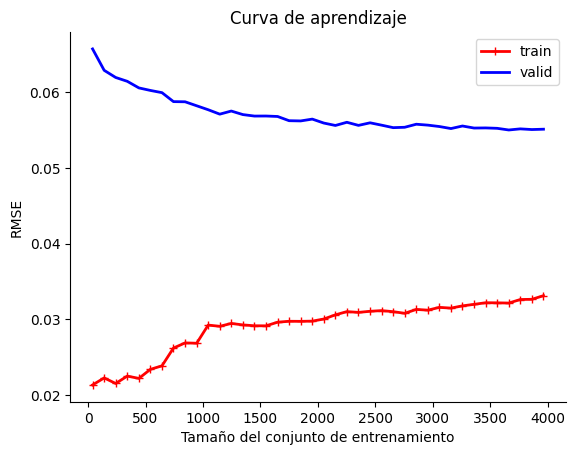

In [18]:
from sklearn.model_selection import learning_curve

# Curva de Aprendizaje
train_sizes, train_scores, valid_scores = learning_curve(
    randomForest, X_train_scaled, y_train_scaled, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=2, label="valid")
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curva de aprendizaje')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Los resultados obtenidos con el **Random Forest Regressor** destacan una ***discrepancia significativa*** entre el rendimiento en el conjunto de entrenamiento `(R2 = 0.8455)` y en el de validación `(R2 = 0.523)`, sugiriendo un posible *sobreajuste*.

La diferencia en el rendimiento entre los conjuntos de entrenamiento y validación sugiere que el modelo puede estar *sobreajustando a los datos de entrenamiento*. La presencia de outliers en variables clave como el precio podría estar afectando negativamente la precisión del modelo. Este análisis inicial indica la necesidad de **revisar nuestro enfoque de preprocesamiento**, especialmente en lo que respecta a la gestión de outliers y la normalización de los datos.

### Kernel Ridge

Mejores parámetros: {'alpha': 0.01, 'gamma': 0.09999999999999999}
Mejor puntuación (neg_mean_squared_error): 0.5650729929236367
MAE: 0.033
MSE: 0.004
RMSE: 0.063
R2: 0.498


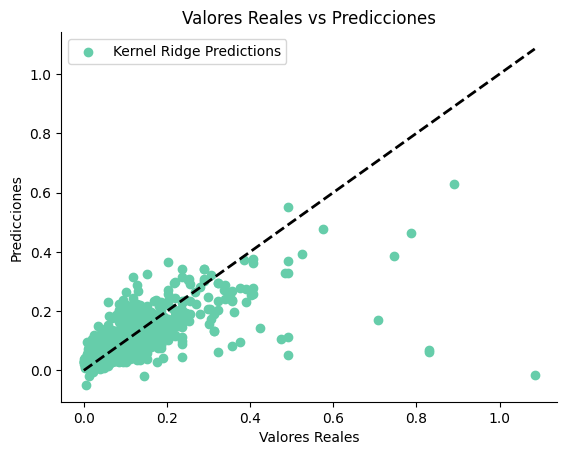

In [19]:
from sklearn.kernel_ridge import KernelRidge

# Definimos y entrenamos el modelo
kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)

kr.fit(X_train_scaled, y_train_scaled)

# Mejores parámetros y mejor puntuación
print("Mejores parámetros:", kr.best_params_)
print("Mejor puntuación (neg_mean_squared_error):", kr.best_score_)

kr_best = kr.best_estimator_

# Predicción
y_pred = kr.predict(X_val_scaled)

# Métricas
metrics = compute_metrics(y_val_scaled, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

plt.scatter(y_val_scaled, y_pred, color='mediumaquamarine', label='Kernel Ridge Predictions')
plt.plot([y_val_scaled.min(), y_val_scaled.max()], [y_val_scaled.min(), y_val_scaled.max()], 'k--', lw=2)  # Línea de identidad
plt.title(f'Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

El gráfico sugiere que el modelo tiene una tendencia a **subestimar los valores más altos**, ya que las predicciones se agrupan por debajo de la línea de predicción perfecta para valores reales más altos. Esto podría indicar una **limitación** en la capacidad del modelo para capturar las dinámicas que conducen a precios más altos, o podría reflejar la presencia de valores atípicos que el modelo no maneja bien.

En general, estos resultados sugieren que, aunque el modelo tiene cierta capacidad predictiva, hay margen de mejora. Las estrategias que podríamos valorar son:

- explorar modelos más complejos
- realizar un preprocesamiento adicional para manejar mejor los outliers
- o incluir características adicionales que puedan explicar la variabilidad en los precios de manera más efectiva.

In [ ]:
from sklearn.model_selection import learning_curve

# Curva de Aprendizaje
train_sizes, train_scores, valid_scores = learning_curve(
    kr, X_train_scaled, y_train_scaled, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=2, label="valid")
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curva de aprendizaje')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Gradient Boosting Regressor

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500, 1000, 1500, 2000]
learningRate = [0.1, 0.05]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }

grid = GridSearchCV(
    GradientBoostingRegressor(random_state = 0, max_depth = 3),
    param_grid=param_grid, cv = 5, verbose = 2)

grid.fit(X_train_scaled, y_train_scaled)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................learning_rate=0.1, n_estimators=500; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................learning_rate=0.1, n_estimators=500; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................learning_rate=0.1, n_estimators=500; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................learning_rate=0.1, n_estimators=500; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................learning_rate=0.1, n_estimators=500; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=   4.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=1500; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=1500; total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=1500; total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=1500; total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=1500; total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=2000; total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=2000; total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=2000; total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=2000; total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.1, n_estimators=2000; total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.05, n_estimators=500; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.05, n_estimators=500; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.05, n_estimators=500; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.05, n_estimators=500; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............learning_rate=0.05, n_estimators=500; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=   4.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=2000; total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=2000; total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=2000; total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=2000; total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..............learning_rate=0.05, n_estimators=2000; total time=  10.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best mean cross-validation score: 0.556
best parameters: {'learning_rate': 0.05, 'n_estimators': 500}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


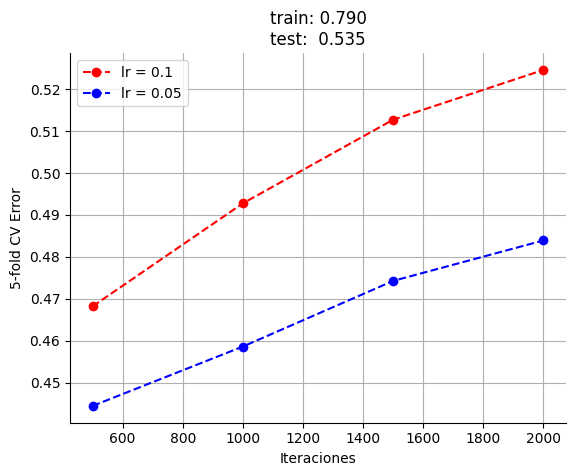

In [22]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train_scaled,y_train_scaled)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('Iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train_scaled,y_train_scaled),bt.score(X_val_scaled,y_val_scaled)))
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid()
plt.show()

In [23]:
print("Train: ", bt.score(X_train_scaled,y_train))
print("Test: ", bt.score(X_test_scaled,y_test))

Train:  -1.4657856740321664
Test:  -1.3769372340898447


MAE: 0.03
MSE: 0.004
RMSE: 0.062
R2: 0.511


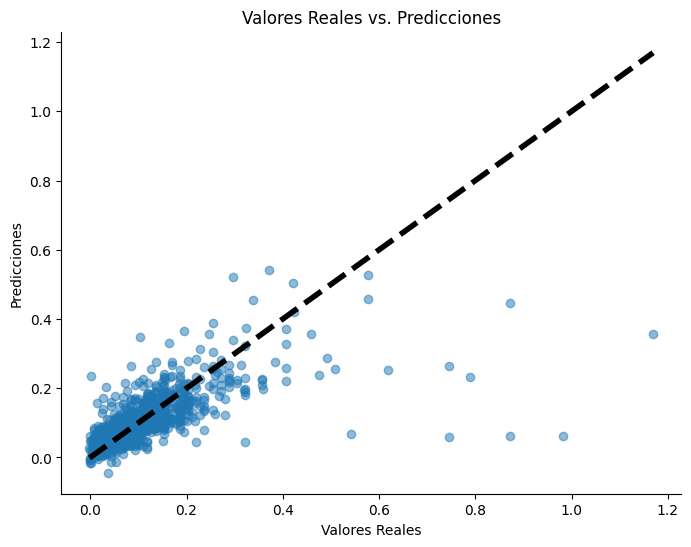

In [25]:
y_pred = bt.predict(X_test_scaled)

# Métricas
metrics = compute_metrics(y_test_scaled, y_pred)

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test_scaled, y_pred, alpha=0.5)
plt.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 'k--', lw=4)  # Línea de perfecta predicción
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Valores Reales vs. Predicciones')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Conclusiones Preliminares y Pasos Futuros

El proceso de modelado ha revelado áreas clave para la mejora, incluyendo la necesidad de un preprocesamiento más refinado y la exploración de arquitecturas de modelos alternativas que puedan manejar mejor la complejidad y diversidad de los datos. Los próximos pasos incluirán una revisión exhaustiva de la estrategia de manejo de outliers, así como experimentar con técnicas avanzadas de regularización para mitigar el sobreajuste observado en el modelo de Random Forest. Además, se considerará la integración de características derivadas adicionales que puedan capturar mejor las interacciones complejas entre las variables.

## Red Neuronal para Datos Tabulares

In [26]:
print(X_train.shape,y_train.shape) # comprobación previa

(4954, 17) (4954, 1)


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Escalador para la variable objetivo
scaler_y = MinMaxScaler()

# Ajustamos y transformamos la variable objetivo
scaler_y.fit(y_train.values.reshape(-1, 1)) # ajustamos el escalador para usarlo después

MinMaxScaler()

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuramos el callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=10,         # Número de épocas sin mejora después de las cuales el entrenamiento se detendrá
    restore_best_weights=True,  # Restaura los pesos del modelo desde la época con la mejor valor de la métrica monitoreada
    verbose=1            # Muestra mensajes cuando se detiene el entrenamiento
)

# definimos la función para entrenar nuestra red con los parámetros deseados
def train_network_decay(learning_rate, lr_decay, batch_size, num_epochs):

    # Implementamos la red empleando Keras
    model = Sequential([
        Dense(128, input_shape=(X_train_scaled.shape[1],), activation="relu", kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
        Dense(1)
    ])

    # Compilamos y entrenamos el modelo SGD
    print("[INFO]: Entrenando red neuronal...")
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate=learning_rate,
        decay_steps=1,
        decay_rate=lr_decay
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

    H = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    epochs_completed = len(H.history['loss'])

    # Evaluamos el modelo de predicción con las imágenes de test
    print("[INFO]: Evaluando red neuronal...")

    predictions = model.predict(X_test_scaled, batch_size=batch_size)
    predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1))  # Convertimos las predicciones escaladas de vuelta a la escala original

    # Comparamos con las predicciones inversamente transformadas con los valores reales (no escalados)
    print("Mean Absolute Error:", mean_absolute_error(y_test, predictions))
    print("R^2 Score:", r2_score(y_test, predictions))

    # Mostramos la gráfica de las métricas
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(range(epochs_completed), H.history['loss'], label='train_loss')
    plt.plot(range(epochs_completed), H.history['val_loss'], label='val_loss')
    plt.plot(range(epochs_completed), H.history['mae'], label='train_mae')
    plt.plot(range(epochs_completed), H.history['val_mae'], label='val_mae')
    plt.title("Training Loss and Mean Absolute Error")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/MAE")
    plt.legend()
    plt.show()

    return model

[INFO]: Entrenando red neuronal...
Epoch 1/10
39/39 [==============================] - 2s 15ms/step - loss: 0.0931 - mae: 0.0648 - val_loss: 0.0411 - val_mae: 0.0371
Epoch 2/10
39/39 [==============================] - 0s 6ms/step - loss: 0.0276 - mae: 0.0419 - val_loss: 0.0184 - val_mae: 0.0371
Epoch 3/10
39/39 [==============================] - 0s 5ms/step - loss: 0.0150 - mae: 0.0415 - val_loss: 0.0130 - val_mae: 0.0382
Epoch 4/10
39/39 [==============================] - 0s 5ms/step - loss: 0.0105 - mae: 0.0397 - val_loss: 0.0091 - val_mae: 0.0344
Epoch 5/10
39/39 [==============================] - 0s 6ms/step - loss: 0.0082 - mae: 0.0379 - val_loss: 0.0076 - val_mae: 0.0370
Epoch 6/10
39/39 [==============================] - 0s 5ms/step - loss: 0.0072 - mae: 0.0376 - val_loss: 0.0071 - val_mae: 0.0350
Epoch 7/10
39/39 [==============================] - 0s 6ms/step - loss: 0.0065 - mae: 0.0374 - val_loss: 0.0063 - val_mae: 0.0373
Epoch 8/10
39/39 [==============================] - 0s

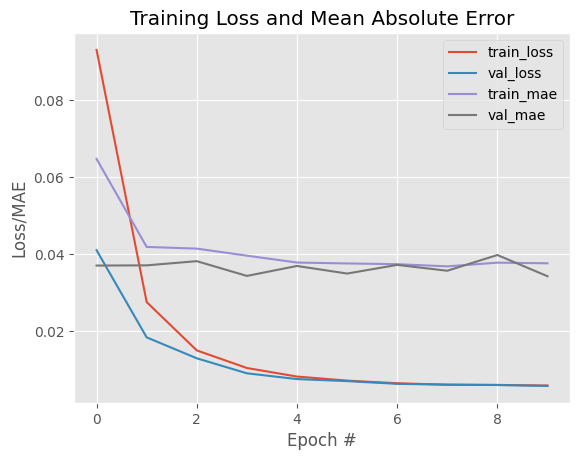

In [43]:
# Hacemos la primera prueba
# Entrenamos el modelo
learning_rate = 0.005
lr_decay = 0.001
num_epochs = 10
batch_size = 128
model_tab = train_network_decay(learning_rate, lr_decay, batch_size, num_epochs)

In [41]:
# Después del entrenamiento, evaluamos el modelo con el conjunto de test
test_loss, test_mae = model_tab.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MAE: {test_mae}")

# Realizamos algunas predicciones con el modelo
sample_indexes = np.random.choice(range(len(X_test_scaled)), 3, replace=False)
sample_inputs = X_test_scaled.iloc[sample_indexes]
sample_targets = y_test.iloc[sample_indexes].values
predictions = model_tab.predict(sample_inputs)
predictions = scaler_y.inverse_transform(predictions)

# Mostramos las predicciones
for i, (index, target, prediction) in enumerate(zip(sample_indexes, sample_targets, predictions.flatten())):
    target_scalar = target.item()  # Esto convierte el array de un solo elemento en un escalar.
    print(f"Ejemplo {index}: Precio Real: {target_scalar}, Precio Predicho: {prediction:.2f}")

Test MAE: 0.03490724414587021
1/1 [==============================] - 0s 142ms/step
Ejemplo 1374: Precio Real: 84.0, Precio Predicho: 90.42
Ejemplo 378: Precio Real: 90.0, Precio Predicho: 75.44
Ejemplo 842: Precio Real: 63.0, Precio Predicho: 54.14


[INFO]: Entrenando red neuronal...
Epoch 1/50
39/39 [==============================] - 2s 31ms/step - loss: 0.0452 - mae: 0.0522 - val_loss: 0.0098 - val_mae: 0.0431
Epoch 2/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0078 - mae: 0.0427 - val_loss: 0.0068 - val_mae: 0.0363
Epoch 3/50
39/39 [==============================] - 0s 5ms/step - loss: 0.0064 - mae: 0.0407 - val_loss: 0.0060 - val_mae: 0.0389
Epoch 4/50
39/39 [==============================] - 0s 6ms/step - loss: 0.0061 - mae: 0.0408 - val_loss: 0.0061 - val_mae: 0.0341
Epoch 5/50
39/39 [==============================] - 0s 5ms/step - loss: 0.0060 - mae: 0.0405 - val_loss: 0.0057 - val_mae: 0.0350
Epoch 6/50
39/39 [==============================] - 0s 6ms/step - loss: 0.0062 - mae: 0.0419 - val_loss: 0.0059 - val_mae: 0.0412
Epoch 7/50
39/39 [==============================] - 0s 5ms/step - loss: 0.0061 - mae: 0.0418 - val_loss: 0.0056 - val_mae: 0.0337
Epoch 8/50
39/39 [==============================] - 0

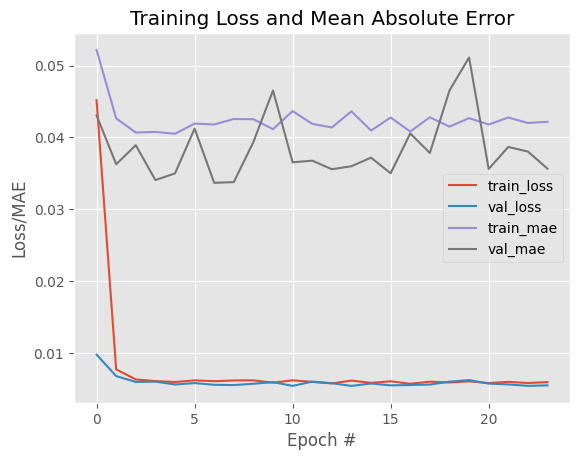

In [44]:
# segunda prueba
learning_rate = 0.01
lr_decay = 1e-3
n_epochs = 50
batch_size = 128
model2 = train_network_decay(learning_rate, lr_decay, batch_size, n_epochs)

In [45]:
# Después del entrenamiento, evaluamos el modelo con el conjunto de test
test_loss, test_mae = model2.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MAE: {test_mae}")

# Realizamos algunas predicciones con el modelo
sample_indexes = np.random.choice(range(len(X_test_scaled)), 3, replace=False)
sample_inputs = X_test_scaled.iloc[sample_indexes]
sample_targets = y_test.iloc[sample_indexes].values
predictions = model2.predict(sample_inputs)
predictions = scaler_y.inverse_transform(predictions)  # transformamos las predicciones de vuelta a la escala original

# Mostramos las predicciones
for i, (index, target, prediction) in enumerate(zip(sample_indexes, sample_targets, predictions.flatten())):
    target_scalar = target.item()  # Esto convierte el array de un solo elemento en un escalar.
    print(f"Ejemplo {index}: Precio Real: {target_scalar}, Precio Predicho: {prediction:.2f}")

Test MAE: 0.035736311227083206
1/1 [==============================] - 0s 17ms/step
Ejemplo 1490: Precio Real: 24.0, Precio Predicho: 41.00
Ejemplo 730: Precio Real: 85.0, Precio Predicho: 71.67
Ejemplo 466: Precio Real: 85.0, Precio Predicho: 79.92


[INFO]: Entrenando red neuronal...
Epoch 1/100
155/155 [==============================] - 2s 7ms/step - loss: 0.0243 - mae: 0.0508 - val_loss: 0.0068 - val_mae: 0.0377
Epoch 2/100
155/155 [==============================] - 1s 5ms/step - loss: 0.0073 - mae: 0.0466 - val_loss: 0.0066 - val_mae: 0.0430
Epoch 3/100
155/155 [==============================] - 1s 5ms/step - loss: 0.0072 - mae: 0.0477 - val_loss: 0.0065 - val_mae: 0.0428
Epoch 4/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0071 - mae: 0.0488 - val_loss: 0.0068 - val_mae: 0.0491
Epoch 5/100
155/155 [==============================] - 1s 6ms/step - loss: 0.0075 - mae: 0.0514 - val_loss: 0.0070 - val_mae: 0.0440
Epoch 6/100
155/155 [==============================] - 1s 6ms/step - loss: 0.0074 - mae: 0.0510 - val_loss: 0.0069 - val_mae: 0.0416
Epoch 7/100
155/155 [==============================] - 1s 8ms/step - loss: 0.0076 - mae: 0.0528 - val_loss: 0.0074 - val_mae: 0.0516
Epoch 8/100
155/155 [=============

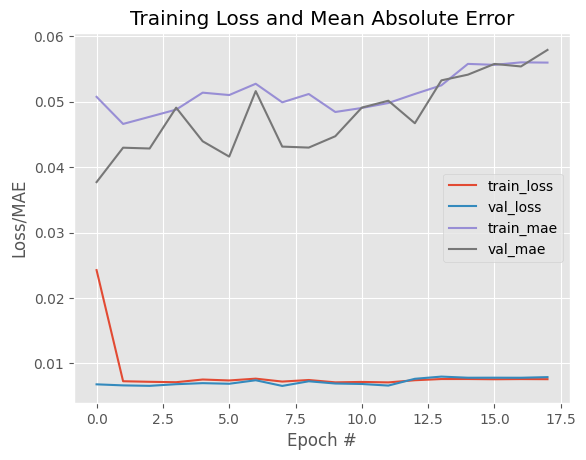

In [47]:
# tercera prueba
learning_rate = 0.01
lr_decay = 1e-6
n_epochs = 100
batch_size = 32
model3 = train_network_decay(learning_rate, lr_decay, batch_size, n_epochs)

In [48]:
# Después del entrenamiento, evaluamos el modelo con el conjunto de test
test_loss, test_mae = model3.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MAE: {test_mae}")

# Predicciones
sample_indexes = np.random.choice(range(len(X_test_scaled)), 3, replace=False)
sample_inputs = X_test_scaled.iloc[sample_indexes]
sample_targets = y_test.iloc[sample_indexes].values
predictions = model3.predict(sample_inputs)
predictions = scaler_y.inverse_transform(predictions)  # Transformamos las predicciones de vuelta a la escala original

# Mostramos las predicciones
for i, (index, target, prediction) in enumerate(zip(sample_indexes, sample_targets, predictions.flatten())):
    target_scalar = target.item()  # Esto convierte el array de un solo elemento en un escalar.
    print(f"Ejemplo {index}: Precio Real: {target_scalar}, Precio Predicho: {prediction:.2f}")

Test MAE: 0.042366981506347656
1/1 [==============================] - 0s 17ms/step
Ejemplo 1018: Precio Real: 80.0, Precio Predicho: 72.86
Ejemplo 1472: Precio Real: 30.0, Precio Predicho: 47.60
Ejemplo 1579: Precio Real: 90.0, Precio Predicho: 75.66


[INFO]: Entrenando red neuronal...
Epoch 1/100
155/155 [==============================] - 3s 7ms/step - loss: 0.1172 - mae: 0.0743 - val_loss: 0.0711 - val_mae: 0.0409
Epoch 2/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0516 - mae: 0.0478 - val_loss: 0.0370 - val_mae: 0.0368
Epoch 3/100
155/155 [==============================] - 1s 5ms/step - loss: 0.0288 - mae: 0.0431 - val_loss: 0.0220 - val_mae: 0.0345
Epoch 4/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0182 - mae: 0.0401 - val_loss: 0.0148 - val_mae: 0.0332
Epoch 5/100
155/155 [==============================] - 1s 5ms/step - loss: 0.0127 - mae: 0.0383 - val_loss: 0.0109 - val_mae: 0.0338
Epoch 6/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0096 - mae: 0.0373 - val_loss: 0.0086 - val_mae: 0.0359
Epoch 7/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0079 - mae: 0.0376 - val_loss: 0.0076 - val_mae: 0.0393
Epoch 8/100
155/155 [=============

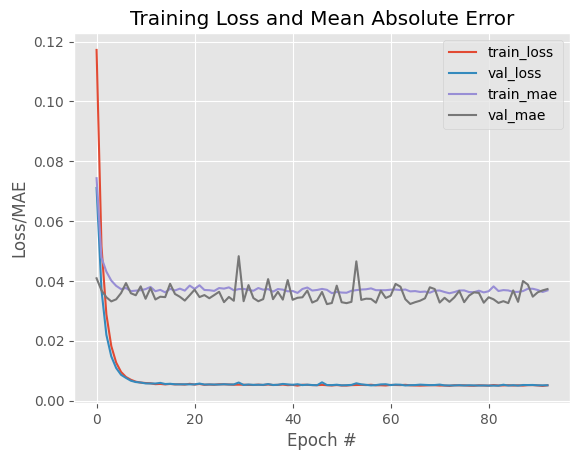

In [50]:
learning_rate = 0.001
lr_decay = 1e-6
n_epochs = 100
batch_size = 32
model4 = train_network_decay(learning_rate, lr_decay, batch_size, n_epochs)

In [51]:
# Después del entrenamiento, evaluamos el modelo con el conjunto de test
test_loss, test_mae = model4.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MAE: {test_mae}")

# Predicciones
sample_indexes = np.random.choice(range(len(X_test_scaled)), 3, replace=False)
sample_inputs = X_test_scaled.iloc[sample_indexes]
sample_targets = y_test.iloc[sample_indexes].values
predictions = model4.predict(sample_inputs)
predictions = scaler_y.inverse_transform(predictions)  # Transformamos las predicciones de vuelta a la escala original

# Mostramos las predicciones
for i, (index, target, prediction) in enumerate(zip(sample_indexes, sample_targets, predictions.flatten())):
    target_scalar = target.item()  # Esto convierte el array de un solo elemento en un escalar.
    print(f"Ejemplo {index}: Precio Real: {target_scalar}, Precio Predicho: {prediction:.2f}")

Test MAE: 0.032630227506160736
1/1 [==============================] - 0s 23ms/step
Ejemplo 442: Precio Real: 130.0, Precio Predicho: 78.82
Ejemplo 4: Precio Real: 29.0, Precio Predicho: 33.76
Ejemplo 768: Precio Real: 130.0, Precio Predicho: 91.20


#### Planteamos la función anterior de otra forma

In [56]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_network_decay_2(learning_rate, lr_decay, batch_size, num_epochs):

    # Implementamos la red empleando Keras
    model = Sequential([
        Dense(128, input_shape=(X_train_scaled.shape[1],), activation="relu", kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
        Dense(1)
    ])

    # Compilamos y entrenamos el modelo SGD
    print("[INFO]: Entrenando red neuronal...")
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate=learning_rate,
        decay_steps=1,
        decay_rate=lr_decay
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

    H = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    epochs_completed = len(H.history['loss'])

    # Evaluamos el modelo de predicción con las imágenes de test
    print("[INFO]: Evaluando red neuronal...")

    predictions = model.predict(X_test_scaled, batch_size=batch_size)
    predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1))  # Convertimos las predicciones escaladas de vuelta a la escala original

    return model, H

[INFO]: Entrenando red neuronal...
Epoch 1/10
39/39 [==============================] - 5s 49ms/step - loss: 0.1092 - mae: 0.0767 - val_loss: 0.0583 - val_mae: 0.0418
Epoch 2/10
39/39 [==============================] - 0s 9ms/step - loss: 0.0419 - mae: 0.0456 - val_loss: 0.0298 - val_mae: 0.0383
Epoch 3/10
39/39 [==============================] - 0s 10ms/step - loss: 0.0238 - mae: 0.0425 - val_loss: 0.0187 - val_mae: 0.0402
Epoch 4/10
39/39 [==============================] - 0s 9ms/step - loss: 0.0159 - mae: 0.0407 - val_loss: 0.0133 - val_mae: 0.0342
Epoch 5/10
39/39 [==============================] - 0s 11ms/step - loss: 0.0119 - mae: 0.0402 - val_loss: 0.0105 - val_mae: 0.0366
Epoch 6/10
39/39 [==============================] - 0s 11ms/step - loss: 0.0096 - mae: 0.0393 - val_loss: 0.0087 - val_mae: 0.0353
Epoch 7/10
39/39 [==============================] - 0s 9ms/step - loss: 0.0083 - mae: 0.0384 - val_loss: 0.0081 - val_mae: 0.0355
Epoch 8/10
39/39 [==============================] -

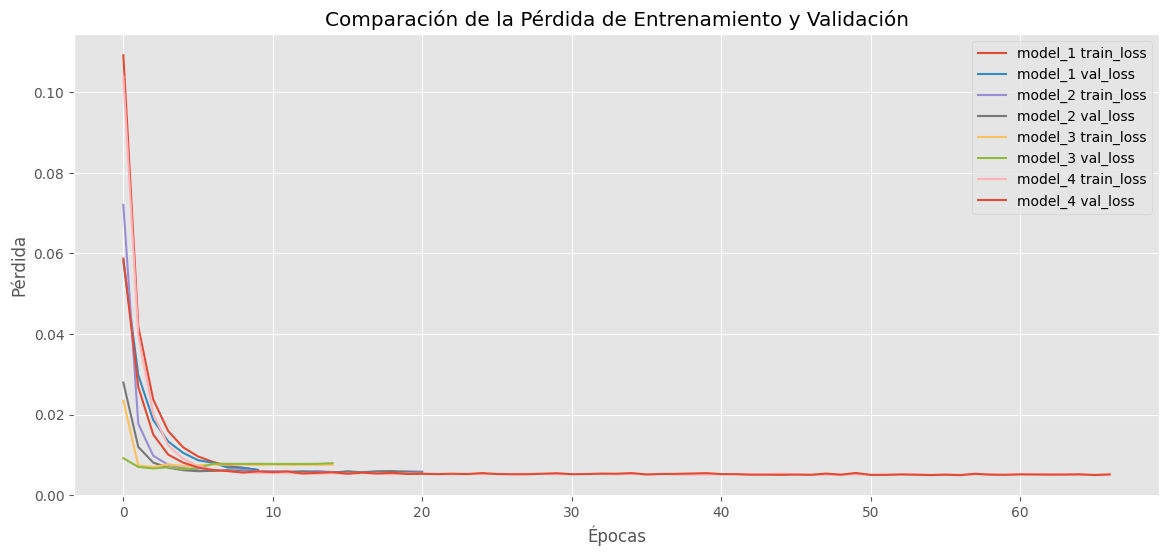

In [58]:
# Configuraciones de los modelos que quieres probar
model_configs = [
    {"learning_rate": 0.005, "lr_decay": 0.001, "num_epochs": 10, "batch_size": 128},
    {"learning_rate": 0.01, "lr_decay": 1e-3, "num_epochs": 50, "batch_size": 128},
    {"learning_rate": 0.01, "lr_decay": 1e-6, "num_epochs": 100, "batch_size": 32},
    {"learning_rate": 0.001, "lr_decay": 1e-6, "num_epochs": 100, "batch_size": 32}
]

# Diccionarios para almacenar los resultados
model_histories = {}

# Bucle para entrenar cada configuración y almacenar los resultados
for i, config in enumerate(model_configs):
    model, H = train_network_decay_2(**config)
    model_histories[f"model_{i+1}"] = H

# Gráficas de comparación
plt.figure(figsize=(14, 6))

for i, history in model_histories.items():
    plt.plot(history.history['loss'], label=f"{i} train_loss")
    plt.plot(history.history['val_loss'], label=f"{i} val_loss")

plt.title("Comparación de la Pérdida de Entrenamiento y Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

Los resultados indican que el modelo actual no tiene un buen ajuste a los datos.

Debemos:
- Revisar y mejorar el preprocesamiento de datos.
- Experimentar con diferentes arquitecturas de red.
- Ajustar hiperparámetros como la tasa de aprendizaje y el número de épocas.
- Utilizar técnicas de regularización para evitar el sobreajuste.
- Revisar la calidad de los datos y considerar la ingeniería de características para mejorar las entradas al modelo.
- Comparar con otros modelos de machine learning para verificar si es un problema específico de la red neuronal.

### Resumen del proceso

1. **Desarrollo de una Red Neuronal de Capas Dense:** Hemos creado una red neuronal utilizando la clase `Sequential` de Keras, y hemos añadido capas densas (`Dense`) con regularización y capas de `Dropout` para prevenir el sobreajuste.

2. **Manejo de Features de Entrada:** Al especificar `input_shape=(X_train_scaled.shape[1],)` en la primera capa `Dense`, estamos asegurando que la red pueda manejar un número constante de features de entrada, que es una práctica adecuada para trabajar con datos tabulares.

3. **Uso de Callback de EarlyStopping:** Implementamos `EarlyStopping` para monitorear la pérdida de validación y detener el entrenamiento si no se observan mejoras, lo cual es una técnica recomendada para optimizar el proceso de entrenamiento y seleccionar el mejor modelo.

4. **Evaluación del Modelo:** Realizamos predicciones con el modelo entrenado y evaluamos su rendimiento con métricas estándar (MAE y R^2), y luego visualizamos los resultados de entrenamiento y validación a lo largo de las épocas (importante para diagnosticar problemas como el sobreajuste).

5. **Ajuste de Hiperparámetros:** Probamos diferentes tasas de aprendizaje, decaimientos y tamaños de lote para intentar afinar el modelo y mejorar su capacidad predictiva.

6. **Escalado de Datos:** Ajustamos los datos para el entrenamiento y evaluación del modelo en su forma escalada y luego invertimos el escalado para interpretar las métricas.

## Red Neuronal para Imágenes

In [62]:
print(imagenes_train.shape, imagenes_test.shape, imagenes_val.shape)

(4954, 224, 224, 3) (1658, 224, 224, 3) (1654, 224, 224, 3)


In [ ]:
# Verificación
print(len(X_train) == len(imagenes_train))
print(len(X_val) == len(imagenes_val))
print(len(X_test) == len(imagenes_test))

True
True
True


Confirmamos que el número de registros en los conjuntos de datos tabulares coincide con el número de imágenes en los conjuntos de imágenes correspondientes:

## ResNet50

In [63]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize

def build_resnet50_regression_model(input_shape=(224, 224, 3)):

  base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

  # Congelamos las capas del modelo base para no entrenarlas
  for layer in base_model.layers:
      layer.trainable = False

  # Agregamos capas personalizadas para la tarea de regresión
  x = base_model.output
  x = GlobalAveragePooling2D()(x)    # Pooling para reducir la dimensionalidad
  x = Dense(2048, activation='relu')(x)  # Aumentamos el número de neuronas
  x = Dropout(0.3)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  output_layer = Dense(1)(x)  # Capa de salida para regresión

  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer=Adam(learning_rate=0.001), # Probamos con diferentes valores
                      loss='mean_squared_error',
                      metrics=['mae'])

  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  history = model.fit(
    imagenes_train, y_train,
    batch_size=32,
    epochs=30,
    validation_data=(imagenes_val, y_val),
    callbacks=[early_stopping]
  )

  return model

# Función para predecir el precio de una vivienda
def predict_house_price_resnet50(model, image_array, scaler_y):
    image_size_required = (224, 224)  # Tamaño de entrada para ResNet50

    # Ajustamos el tamaño de la imagen si no coincide con el esperado
    if image_array.shape[:2] != image_size_required:
        image_array_resized = resize(image_array, image_size_required, preserve_range=True, anti_aliasing=True).astype(np.float32)
    else:
        image_array_resized = image_array

    # Preprocesamos la imagen
    image_array_resized = preprocess_input(np.expand_dims(image_array_resized, axis=0))

    # Hacemos la predicción
    predicted_price_scaled = model.predict(image_array_resized)

    # Aplicamos la transformación inversa a la predicción si es necesario
    predicted_price = scaler_y.inverse_transform(predicted_price_scaled)

    return predicted_price[0][0]

Explicación del proceso:

- **Construcción del modelo:** Utilizamos `Resnet50` como base, sin incluir las capas superiores (`include_top=False`) (esto es adecuado para la extracción de características que haremos más adelante). Después, agregamos capas personalizadas ajustadas a regresión.
- **Congelación de capas:** Garantizamos que solo las capas que hemos agregado se entrenarán.
- **Compilación del modelo:** Compilamos el modelo con un learning rate específico, una función de pérdida (`mean_squared_error`) y métricas.
- **Función de predicción:** Ajustamos el tamaño de las imágenes de entrada, las procesamos, realizamos las predicciones y luego aplicamos una transformación inversa para obtener los precios en su escala original.

In [64]:
model_resnet = build_resnet50_regression_model()

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/30
155/155 [==============================] - 38s 195ms/step - loss: 2499.8162 - mae: 30.7532 - val_loss: 2410.5657 - val_mae: 30.0979
Epoch 2/30
155/155 [==============================] - 26s 168ms/step - loss: 2232.0327 - mae: 28.7397 - val_loss: 2398.0422 - val_mae: 30.3027
Epoch 3/30
155/155 [==============================] - 20s 130ms/step - loss: 2134.4441 - mae: 28.2732 - val_loss: 2554.2839 - val_mae: 27.4124
Epoch 4/30
155/155 [==============================] - 21s 136ms/step - loss: 2013.2755 - mae: 27.8395 - val_loss: 2373.6379 - val_mae: 28.0916
Epoch 5/30
155/155 [==============================] - 21s 133ms/step - loss: 1924.7943 - mae: 27.3218 - val_loss: 2533.4705 - val_mae: 27.6319
Epoch 6/30
155/155 [==============================] - 20s 130ms/step - loss: 1829.7479 - mae: 27.6084 - val_loss: 2454.5413 - val_mae: 29.5004
Epoch 7/30
155/155 [==============================] - 20s 131ms/step - loss: 

In [67]:
image_to_predict = imagenes_cargadas[10]
predicted_price = predict_house_price_resnet50(model_resnet, image_to_predict, scaler_y)
print(f"El precio predicho de la vivienda es: ${predicted_price}")

1/1 [==============================] - 0s 38ms/step
El precio predicho de la vivienda es: $15178.01171875


array([[[60, 52, 41],
        [60, 52, 41],
        [60, 52, 41],
        ...,
        [59, 53, 41],
        [58, 52, 40],
        [58, 52, 40]],

       [[60, 52, 41],
        [60, 52, 41],
        [60, 52, 41],
        ...,
        [59, 53, 41],
        [58, 52, 40],
        [58, 52, 40]],

       [[60, 52, 41],
        [60, 52, 41],
        [60, 52, 41],
        ...,
        [59, 53, 41],
        [58, 52, 40],
        [58, 52, 40]],

       ...,

       [[17, 10,  4],
        [18, 11,  5],
        [18, 11,  5],
        ...,
        [26, 17, 12],
        [26, 17, 12],
        [26, 17, 12]],

       [[17, 10,  4],
        [18, 11,  5],
        [18, 11,  5],
        ...,
        [26, 17, 12],
        [26, 17, 12],
        [26, 17, 12]],

       [[17, 10,  4],
        [18, 11,  5],
        [18, 11,  5],
        ...,
        [26, 17, 12],
        [26, 17, 12],
        [26, 17, 12]]], dtype=uint8)
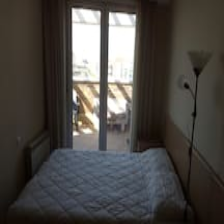

In [69]:
image_to_predict

In [68]:
# Evaluamos el modelo
test_loss, test_mae = model_resnet.evaluate(imagenes_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

52/52 [==============================] - 5s 96ms/step - loss: 2520.1257 - mae: 27.5043
Test Loss: 2520.125732421875
Test MAE: 27.50434684753418


El modelo no da buenos resultados pero sabemos que el desarrollo de modelos de deep learning es iterativo y se necesitan varios ciclos de ajuste y evaluación para encontrar la configuración óptima.

Para mejorar el modelo debemos:
- **Revisar el preprocesamiento de los datos:** Asegurarnos de que las imágenes estén correctamente procesadas.
- **Ajustar la Arquitectura del Modelo:** Cambiar el número de neuronas en las capas densas, modificar la tasa de dropout o probar con diferentes modelos preentrenados.
- **Optimización de Hiperparámetros:** Experimentar con diferentes tasas de aprendizaje, batch size y otras configuraciones del optimizador.
- **Validación cruzada:** Útil si el modelo está sobreajustando a un subconjunto específicos de los datos.
- **Aumento de Datos (Data Augmentation):** Para amplicar el conjunto de entrenamiento y mejorar la capacidad de generalización del modelo.
- **Revisar las etiquetas:** Comprobar que los precios de las viviendas estén escalado adecuadamente y que estemos usando el *scaler* correcto para desescalar las predicciones antes de evaluar el modelo.

### Descongelación de Capas y Fine-Tuning

Una vez completado el entrenamiento inicial, probamos a ajustar las capas a entrenar y reducir la tasa de aprendizaje para el *fine-tuning*:

In [70]:
from tensorflow.keras.layers import BatchNormalization

# 'model_resnet' es nuestro modelo ya construido y entrenado
for layer in model_resnet.layers[-10:]:  # Podemos ajustarlo
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model_resnet.compile(optimizer=Adam(learning_rate=1e-4),  # Tasa más baja para fine-tuning
                     loss='mean_squared_error',
                     metrics=['mae'])

# Continuamos el entrenamiento con fine-tuning
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_fine_tuning = model_resnet.fit(
    imagenes_train, y_train,
    batch_size=32,
    epochs=20,  # Podemos ajustarlo
    validation_data=(imagenes_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
155/155 [==============================] - 69s 201ms/step - loss: 1879.6869 - mae: 26.6669 - val_loss: 2407.1965 - val_mae: 27.6175
Epoch 2/20
155/155 [==============================] - 20s 132ms/step - loss: 1607.0823 - mae: 25.0638 - val_loss: 2539.0535 - val_mae: 30.6412
Epoch 3/20
155/155 [==============================] - 21s 133ms/step - loss: 1378.2626 - mae: 24.1137 - val_loss: 2491.7385 - val_mae: 28.8908
Epoch 4/20
155/155 [==============================] - 21s 133ms/step - loss: 1126.0986 - mae: 22.3607 - val_loss: 2568.7610 - val_mae: 30.4047
Epoch 5/20
155/155 [==============================] - 20s 132ms/step - loss: 872.7521 - mae: 20.1197 - val_loss: 2581.5586 - val_mae: 30.3031
Epoch 6/20
155/155 [==============================] - 21s 133ms/step - loss: 679.8058 - mae: 18.4812 - val_loss: 2595.2585 - val_mae: 29.8043
Epoch 7/20
155/155 [==============================] - 21s 133ms/step - loss: 542.6652 - mae: 16.9445 - val_loss: 2677.4033 - val_mae: 31.0934
Ep

In [72]:
image_to_predict = imagenes_cargadas[10]
predicted_price = predict_house_price_resnet50(model_resnet, image_to_predict, scaler_y)
print(f"El precio predicho de la vivienda es: ${predicted_price}")

1/1 [==============================] - 0s 38ms/step
El precio predicho de la vivienda es: $18021.970703125


In [73]:
# Evaluamos el modelo
test_loss, test_mae = model_resnet.evaluate(imagenes_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

52/52 [==============================] - 5s 94ms/step - loss: 2540.6155 - mae: 27.2307
Test Loss: 2540.615478515625
Test MAE: 27.23065185546875


## VGG16

In [74]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

def build_inceptionv3_regression_model(input_shape=(299, 299, 3)):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelamos las capas del modelo base para no entrenarlas
    for layer in base_model.layers:
        layer.trainable = False

    # Agregamos capas personalizadas para la tarea de regresión
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_layer = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

In [75]:
# Función para predecir el precio de una vivienda
def predict_house_price_inceptionv3(model, image_array, scaler_y):
    image_size_required = (299, 299)  # Tamaño de entrada para ResNet50

    # Ajustamos el tamaño de la imagen si no coincide con el esperado
    if image_array.shape[:2] != image_size_required:
        image_array_resized = resize(image_array, image_size_required, preserve_range=True, anti_aliasing=True).astype(np.float32)
    else:
        image_array_resized = image_array

    # Preprocesamos la imagen
    image_array_resized = preprocess_input(np.expand_dims(image_array_resized, axis=0))

    # Hacemos la predicción
    predicted_price_scaled = model.predict(image_array_resized)

    # Aplicamos la transformación inversa a la predicción si es necesario
    predicted_price = scaler_y.inverse_transform(predicted_price_scaled)

    return predicted_price[0][0]

In [76]:
model_inceptionv3 = build_inceptionv3_regression_model()

87910968/87910968 [==============================] - 1s 0us/step


In [79]:
image_to_predict = imagenes_cargadas[240]
predicted_price = predict_house_price_inceptionv3(model_inceptionv3, image_to_predict, scaler_y)
print(f"El precio predicho de la vivienda es: ${predicted_price}")

1/1 [==============================] - 0s 54ms/step
El precio predicho de la vivienda es: $156.44578552246094


array([[[186, 187, 182],
        [200, 201, 196],
        [153, 154, 149],
        ...,
        [238, 242, 245],
        [238, 242, 245],
        [238, 242, 245]],

       [[188, 189, 184],
        [200, 202, 197],
        [159, 160, 155],
        ...,
        [238, 242, 245],
        [238, 242, 245],
        [238, 242, 245]],

       [[190, 192, 187],
        [202, 202, 197],
        [168, 169, 164],
        ...,
        [238, 242, 245],
        [238, 242, 245],
        [238, 242, 245]],

       ...,

       [[160, 119, 114],
        [ 56,  12,   6],
        [ 85,  35,  16],
        ...,
        [ 82,  82,  91],
        [ 73,  76,  88],
        [ 65,  71,  83]],

       [[161, 120, 116],
        [ 59,  15,   9],
        [ 89,  37,  21],
        ...,
        [ 82,  82,  91],
        [ 72,  77,  87],
        [ 64,  70,  82]],

       [[162, 121, 119],
        [ 62,  17,  11],
        [ 91,  39,  24],
        ...,
        [ 82,  82,  91],
        [ 72,  76,  88],
        [ 64,  70,  82]]], dtype=uint8)
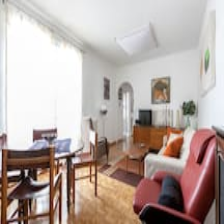

In [80]:
image_to_predict

In [81]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
import math

def preprocess_and_evaluate_in_batches(model, images, labels, batch_size=32):
    num_images = len(images)
    num_batches = math.ceil(num_images / batch_size)

    total_loss = 0
    total_mae = 0

    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = min(batch_start + batch_size, num_images)
        images_batch = images[batch_start:batch_end]

        # Preprocesamos las imágenes del lote actual
        images_batch_preprocessed = np.array([resize(image, (299, 299), preserve_range=True, anti_aliasing=True) for image in images_batch])
        images_batch_preprocessed = preprocess_input(images_batch_preprocessed)

        # Obtenemos las etiquetas correspondientes al lote actual
        labels_batch = labels[batch_start:batch_end]

        # Evaluamos el lote actual
        loss, mae = model.evaluate(images_batch_preprocessed, labels_batch, verbose=0)

        total_loss += loss * (batch_end - batch_start)
        total_mae += mae * (batch_end - batch_start)

    # Calculamos el promedio de pérdida y MAE sobre todos los lotes
    avg_loss = total_loss / num_images
    avg_mae = total_mae / num_images

    return avg_loss, avg_mae

# Ejemplo de uso
test_loss, test_mae = preprocess_and_evaluate_in_batches(model_inceptionv3, imagenes_test, y_test, batch_size=32)
print(f"Test Loss con InceptionV3: {test_loss}")
print(f"Test MAE con InceptionV3: {test_mae}")

Test Loss con InceptionV3: 6562.8451689017265
Test MAE con InceptionV3: 61.64323928704164


In [83]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (224, 224, 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

datagen_train = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Configura las capas como no entrenables o entrenables según sea necesario
for layer in base_model.layers:
    layer.trainable = False
    if layer.name == "block5_conv3":
        layer.trainable = True

# Añade las capas personalizadas para la tarea de regresión
last = base_model.output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
# Capa de salida para regresión
output_layer = Dense(1, activation='linear', name='output')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compila el modelo para regresión
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['mean_squared_error'])

# Resumen del modelo
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [84]:
image_to_predict = imagenes_cargadas[6]

# `image_to_predict` es un ndarray con forma (224, 224, 3)
image_to_predict_preprocessed = tf.keras.applications.vgg16.preprocess_input(np.expand_dims(image_to_predict, axis=0))

# Ahora `image_to_predict_preprocessed` debería tener forma (1, 224, 224, 3)
predicted_price_scaled = model.predict(image_to_predict_preprocessed)

# Aplicamos la transformación inversa
predicted_price = scaler_y.inverse_transform(predicted_price_scaled)

print(f"El precio predicho de la vivienda es: ${predicted_price[0][0]}")

1/1 [==============================] - 1s 1s/step
El precio predicho de la vivienda es: $4729.73095703125


In [ ]:
""" # no puedo procesarlo, la sesión falla porque se ha usado toda la memoria disponible
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preparar el generador de datos de validación sin data augmentation
datagen_val = ImageDataGenerator()

datagen_train.fit(imagenes_train)

# Ajusta el modelo
history = model.fit(
    datagen_train.flow(imagenes_train, y_train, batch_size=32),
    validation_data=datagen_val.flow(imagenes_val, y_val, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32,
    epochs=10
)
"""

array([[[ 54,  33,  30],
        [ 64,  43,  40],
        [ 62,  41,  40],
        ...,
        [ 91,  83,  72],
        [ 85,  73,  61],
        [ 73,  61,  49]],

       [[ 54,  33,  30],
        [ 65,  44,  41],
        [ 63,  42,  40],
        ...,
        [ 85,  77,  66],
        [ 81,  70,  58],
        [ 71,  59,  47]],

       [[ 55,  34,  31],
        [ 66,  44,  41],
        [ 64,  42,  41],
        ...,
        [ 79,  71,  60],
        [ 77,  67,  56],
        [ 70,  58,  46]],

       ...,

       [[127,  78,  63],
        [127,  78,  61],
        [130,  79,  62],
        ...,
        [ 66,  40,  39],
        [ 72,  44,  43],
        [ 73,  45,  44]],

       [[132,  83,  66],
        [132,  83,  66],
        [134,  84,  66],
        ...,
        [ 67,  41,  40],
        [ 72,  44,  43],
        [ 71,  43,  42]],

       [[135,  86,  69],
        [135,  86,  69],
        [138,  87,  70],
        ...,
        [ 68,  42,  41],
        [ 72,  44,  43],
        [ 70,  42,  41]]], dtype=uint8)
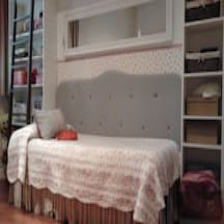

In [ ]:
image_to_predict

### Planteado de otra forma

In [2]:
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input

def predict_house_price(model_name: str, image_array):
    # Diccionario de modelos preentrenados disponibles en Keras
    MODELS = {
        'vgg16': VGG16,
        'vgg19': VGG19,
        'inception': InceptionV3,
        'xception': Xception,
        'resnet50': ResNet50
    }

    # Asegúrate de que el modelo_name es uno de los modelos disponibles
    if model_name not in MODELS:
        raise ValueError("Nombre de modelo no reconocido. Opciones disponibles: 'vgg16', 'vgg19', 'inception', 'xception', 'resnet50'")

    input_shape = (224, 224, 3)
    preprocess = imagenet_utils.preprocess_input

    if model_name in ('inception', 'xception'):
      input_shape = (299, 299, 3)
      preprocess = preprocess_input

    print("[INFO] loading {}...".format(model_name))

    base_model = MODELS[model_name](weights='imagenet', include_top=False, input_shape=input_shape)

    # Creación del modelo para regresión
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Capa densa ajustable
    output_layer = Dense(1)(x)  # Capa de salida para regresión

    model = Model(inputs=base_model.input, outputs=output_layer)

    # Verificar y ajustar el tamaño de la imagen
    if image_array.shape != input_shape:
        print("La imagen proporcionada no tiene el tamaño esperado.", image_array.shape, input_shape)
        # Aquí podrías ajustar el tamaño de la imagen o devolver None para indicar el error
        return None

    image = np.expand_dims(image_array, axis=0)  # Añade una dimensión para 'batch'
    image = preprocess(image)  # Preprocesamiento de la imagen

    predicted_price = model.predict(image)
    predicted_price_original = scaler_y.inverse_transform(predicted_price)

    return predicted_price_original[0][0]

In [10]:
image_to_predict = imagenes_cargadas[20]

predicted_price = predict_house_price('vgg16', image_to_predict)
print(f"El precio predicho de la vivienda es: ${predicted_price}")

[INFO] loading vgg16...
1/1 [==============================] - 0s 145ms/step
El precio predicho de la vivienda es: $1323.2109375


In [11]:
# misma imagen con 'xception'

if image_to_predict.shape != (299, 299, 3):
    print(f"Redimensionando imagen de {image_to_predict.shape} a (299, 299, 3) para el modelo Xception.")
    # Redimensionar la imagen utilizando el método de interpolación más cercano
    image_to_predict = tf.image.resize(image_to_predict, (299, 299), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image_to_predict = image_to_predict.numpy()

predicted_price = predict_house_price('xception', image_to_predict)
print(f"El precio predicho de la vivienda es: ${predicted_price}")

[INFO] loading xception...
83683744/83683744 [==============================] - 1s 0us/step
La imagen proporcionada no tiene el tamaño esperado. (224, 224, 3) (299, 299, 3)
El precio predicho de la vivienda es: $None


In [12]:
# misma imagen con 'resnet50'
predicted_price = predict_house_price('resnet50', image_to_predict)
print(f"El precio predicho de la vivienda es: ${predicted_price}")

[INFO] loading resnet50...
1/1 [==============================] - 2s 2s/step
El precio predicho de la vivienda es: $-424.0163879394531


array([[[111,  83,  43],
        [113,  85,  46],
        [120,  91,  57],
        ...,
        [105,  76,  32],
        [104,  75,  31],
        [104,  75,  31]],

       [[111,  83,  43],
        [113,  85,  46],
        [120,  91,  57],
        ...,
        [105,  76,  32],
        [104,  75,  31],
        [104,  75,  31]],

       [[111,  83,  43],
        [113,  85,  46],
        [120,  91,  57],
        ...,
        [105,  76,  32],
        [105,  76,  32],
        [104,  75,  31]],

       ...,

       [[ 24,  20,   8],
        [ 29,  23,   9],
        [ 26,  18,   3],
        ...,
        [122, 100,  49],
        [118,  98,  46],
        [112,  92,  41]],

       [[ 23,  19,   7],
        [ 28,  22,   8],
        [ 25,  17,   2],
        ...,
        [117,  93,  38],
        [116,  94,  37],
        [113,  93,  34]],

       [[ 23,  19,   7],
        [ 28,  22,   8],
        [ 24,  17,   2],
        ...,
        [111,  86,  29],
        [111,  87,  27],
        [109,  88,  25]]], dtype=uint8)
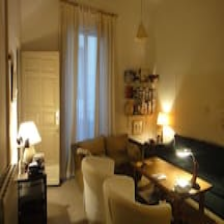

In [13]:
image_to_predict

## Transfering Learning

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input

img_train_preprocessed = preprocess_input(imagenes_train)
img_val_preprocessed = preprocess_input(imagenes_val)
img_test_preprocessed = preprocess_input(imagenes_test)

# Transfer Learning con VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar el modelo base

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1)(x)  # tarea de regresión
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error')

# Data Augmentation
datagen_train = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Entrenamiento con detención temprana
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(datagen_train.flow(img_train_preprocessed, y_train, batch_size=32),
            validation_data=(img_val_preprocessed, y_val),
            epochs=10,
            callbacks=[early_stopping])

# Evaluación del modelo
scores = model.evaluate(img_test_preprocessed, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test MSE:', scores[1])

Epoch 1/10
155/155 [==============================] - 94s 533ms/step - loss: 5199.8760 - val_loss: 4174.3701
Epoch 2/10
155/155 [==============================] - 71s 458ms/step - loss: 3588.4053 - val_loss: 3108.2585
Epoch 3/10
155/155 [==============================] - 75s 484ms/step - loss: 2912.4009 - val_loss: 2811.6887
Epoch 4/10
155/155 [==============================] - 74s 474ms/step - loss: 2733.2673 - val_loss: 2760.9934
Epoch 5/10
155/155 [==============================] - 77s 494ms/step - loss: 2674.7678 - val_loss: 2741.5093
Epoch 6/10
155/155 [==============================] - 71s 461ms/step - loss: 2649.1208 - val_loss: 2721.2632
Epoch 7/10
155/155 [==============================] - 69s 446ms/step - loss: 2611.2546 - val_loss: 2696.4343
Epoch 8/10
155/155 [==============================] - 70s 451ms/step - loss: 2606.5315 - val_loss: 2670.8914
Epoch 9/10
155/155 [==============================] - 71s 458ms/step - loss: 2564.7678 - val_loss: 2652.5774
Epoch 10/10
155/155

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# image_to_predict es un ndarray con forma (224, 224, 3)
image_to_predict_preprocessed = preprocess_input(np.expand_dims(image_to_predict, axis=0))

# Hacemos la predicción
predicted_price_scaled = model.predict(image_to_predict_preprocessed)

# Aplicamos la transformación inversa a la predicción porque las etiquetas fueron escaladas
predicted_price = scaler_y.inverse_transform(predicted_price_scaled)[0][0]

# Mostrar la imagen y el precio predicho
plt.imshow(image_to_predict.astype(np.uint8))
plt.title(f"Precio predicho de la vivienda: ${predicted_price:.2f}")
plt.axis('off')
plt.show()

#3. Fusión de modelos

## Early-Fusion

- Extracción de Características de Imágenes
- Preparación de Datos Tabulares
- Concatenación de Features
- Entrenamiento del Modelo de Fusión

In [ ]:
# Concatenación de features
combined_input = Concatenate()([model4.output, model_model_resnet.output])

# Modelo final para predicción
combined_model = Dense(64, activation='relu')(combined_input)
combined_model = Dense(1, activation='linear')(combined_model)
model = Model(inputs=[model_tabular.input, model_image.input], outputs=combined_model)

# Compilación y entrenamiento
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mae'])

# Asegúrate de ajustar el entrenamiento con los datos adecuados
model.fit([X_train_scaled, imagenes_train], y_train_scaled, validation_data=([X_val_scaled, imagenes_val], y_val_scaled), epochs=10, batch_size=32)

## Late-Fusion

La fusión tardía *(late-fusion)* implica entrenar modelos separados para cada tipo de dato y luego combinar sus predicciones finales. A diferencia de la fusión temprana, donde las características se combinan antes de la capa de decisión, la fusión tardía se refiere a la combinación de las salidas de los modelos justo antes de tomar una decisión final.

In [ ]:
# Realizar predicciones en el conjunto de validación o prueba
pred_tabular = model_tabular.predict(X_test_scaled)
pred_images = model_images.predict(X_test_images)

# Combinar las predicciones (promedio)
combined_predictions = (pred_tabular + pred_images) / 2

# Evaluar las predicciones combinadas
final_mae = mean_absolute_error(y_test, combined_predictions)
print(f'Final MAE with late fusion: {final_mae}')

In [ ]:
# Entrenar el modelo
X_train_meta = np.concatenate((pred_train_tabular, pred_train_images), axis=1)
X_val_meta = np.concatenate((pred_val_tabular, pred_val_images), axis=1)

model